In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# set seanborn style
sns.set_style("whitegrid")

In [2]:
csv_path = os.path.join(os.path.expanduser("~"), "Desktop", "query_result_2025-01-15T17_04_57.113316Z.csv")
df = pd.read_csv(csv_path)
df['created_date'] = df['created_date'].str.split('T').str[0]
df['created_date'] = pd.to_datetime(df['created_date'])

df['wait_time'] = df['wait_time'] / 86400 #in days
df.dropna(inplace=True)
df

,created_date,response_id,support_satisfaction,wait_time
0,2021-10-17,0Ki5J000000fUy4SAE,1.5,0.187859
1,2021-10-17,0Ki5J000000fVOmSAM,0.5,0.003380
2,2021-10-17,0Ki5J000000fVQKSA2,5.0,0.035787
3,2021-10-17,0Ki5J000000fVRkSAM,0.5,0.182731
4,2021-10-17,0Ki5J000000fVTJSA2,4.5,0.004456
...,...,...,...,...
113602,2025-01-15,0Kicj000001fAirCAE,1.0,0.556968
113603,2025-01-15,0Kicj000001fBesCAE,2.0,0.994653
113604,2025-01-15,0Kicj000001fCizCAE,2.0,12.486574
113605,2025-01-15,0Kicj000001fDn9CAE,5.0,7.178403


In [383]:
grouped_df = df.groupby('created_date').agg(response_id_count=('response_id', 'count'),
    avg_support_satisfaction=('support_satisfaction', 'mean'),
    avg_wait_time=('wait_time', 'mean')).reset_index()

grouped_df

,created_date,response_id_count,avg_support_satisfaction,avg_wait_time
0,2021-10-17,5,2.400000,0.082843
1,2021-10-18,44,3.250000,0.258848
2,2021-10-19,73,2.883562,0.421642
3,2021-10-20,99,2.914141,0.676280
4,2021-10-21,87,3.471264,0.670420
...,...,...,...,...
1182,2025-01-11,106,3.009434,4.594721
1183,2025-01-12,115,2.991304,5.117413
1184,2025-01-13,155,2.877419,4.203828
1185,2025-01-14,200,3.245000,3.460374


In [384]:
df.columns[2], df.columns[3]

('support_satisfaction', 'wait_time')

We can see from the table that we have skewed data accross avg_support_satisfaction and avg_wait_time. We can apply transformations to normalize the data.

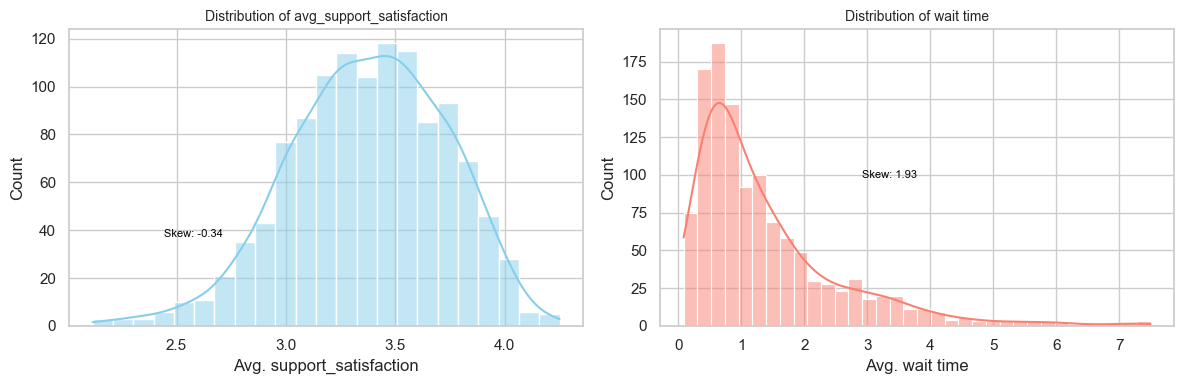

In [390]:
skew_satisfaction = grouped_df['avg_support_satisfaction'].skew()
skew_time = grouped_df['avg_wait_time'].skew()

# Set the style of seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Apply transformations
sns.histplot(grouped_df['avg_support_satisfaction'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of avg_support_satisfaction', fontsize=10)
ax[0].set_xlabel('Avg. support_satisfaction')

ax[0].text(0.3, 0.3, f'Skew: {skew_satisfaction:.2f}', transform=ax[0].transAxes,
           horizontalalignment='right', color='black', fontsize=8)
 
sns.histplot(grouped_df['avg_wait_time'], kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of wait time', fontsize=10)
ax[1].set_xlabel('Avg. wait time')

ax[1].text(0.5, 0.5, f'Skew: {skew_time:.2f}', transform=ax[1].transAxes,
           horizontalalignment='right', color='black', fontsize=8)
 
plt.tight_layout()
plt.show()

In [ ]:
# Apply transformations to avg_support_satisfaction
print(f"Original Skewness: {grouped_df['avg_support_satisfaction'].skew():.5f}")

# Log Transformation
grouped_df['log_avg_support_satisfaction'] = np.log(grouped_df['avg_support_satisfaction'] + 1)  # Add 1 to handle zero values if any
print(f"Skewness after Log Transformation: {grouped_df['log_avg_support_satisfaction'].skew():.5f}")

# Box-Cox Transformation (requires strictly positive values)
grouped_df['BoxCox_avg_support_satisfaction'], _ = boxcox(grouped_df['avg_support_satisfaction'] + 1)  # Add 1 to ensure positivity
print(f"Skewness after Box-Cox Transformation: {grouped_df['BoxCox_avg_support_satisfaction'].skew():.5f}")

# Yeo-Johnson Transformation (handles zero and negative values)
grouped_df['YeoJohnson_avg_support_satisfaction'], _ = yeojohnson(grouped_df['avg_support_satisfaction'])
print(f"Skewness after Yeo-Johnson Transformation: {grouped_df['YeoJohnson_avg_support_satisfaction'].skew():.5f}")

# Quantile Transformation
qt = QuantileTransformer(output_distribution='normal', random_state=0)
grouped_df['Quantile_avg_support_satisfaction'] = qt.fit_transform(grouped_df[['avg_support_satisfaction']])
print(f"Skewness after Quantile Transformation: {grouped_df['Quantile_avg_support_satisfaction'].skew():.5f}") # best performant so far


Original Skewness: -0.34173
Skewness after Log Transformation: -0.59784
Skewness after Box-Cox Transformation: -0.02099
Skewness after Yeo-Johnson Transformation: -0.02099
Skewness after Quantile Transformation: 0.00021


In [399]:
# Apply transformations to avg_wait_time
print(f"Original Skewness: {grouped_df['avg_wait_time'].skew():.5f}")

# Log Transformation
grouped_df['log_avg_wait_time'] = np.log(grouped_df['avg_wait_time'] + 1)  # Add 1 to handle zero values if any
print(f"Log Skewness: {grouped_df['log_avg_wait_time'].skew():.5f}")

# Box-Cox Transformation (requires strictly positive values)
grouped_df['boxcox_avg_wait_time'], _ = stats.boxcox(grouped_df['avg_wait_time'])
print(f"Box-Cox Skewness: {grouped_df['boxcox_avg_wait_time'].skew():.5f}")

# Yeo-Johnson Transformation (handles zero and negative values)
grouped_df['yeojohnson_avg_wait_time'], _ = stats.yeojohnson(grouped_df['avg_wait_time'])
print(f"Yeo-Johnson Skewness: {grouped_df['yeojohnson_avg_wait_time'].skew():.5f}")

# Quantile Transformation
qt = QuantileTransformer(output_distribution='normal', random_state=0)
grouped_df['quantile_avg_wait_time'] = qt.fit_transform(grouped_df[['avg_wait_time']])
print(f"Quantile Skewness: {grouped_df['quantile_avg_wait_time'].skew():.5f}") # best performant so far

Original Skewness: 1.93218
Log Skewness: 0.80142
Box-Cox Skewness: 0.00273
Yeo-Johnson Skewness: 0.11336
Quantile Skewness: 0.00052


Vizualization after transformations


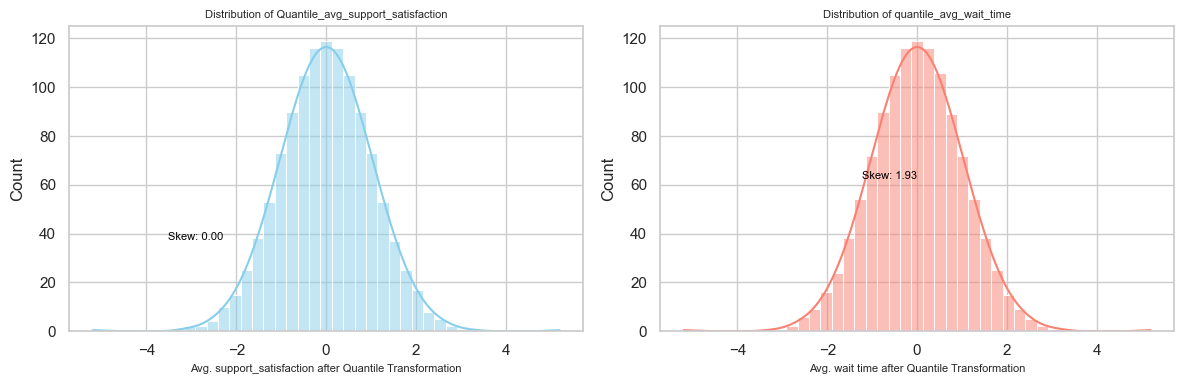

In [400]:
skew_satisfaction = grouped_df['Quantile_avg_support_satisfaction'].skew()
skew_time = grouped_df['avg_wait_time'].skew()

# Set the style of seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Apply transformations
sns.histplot(grouped_df['Quantile_avg_support_satisfaction'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Quantile_avg_support_satisfaction', fontsize=8)
ax[0].set_xlabel('Avg. support_satisfaction after Quantile Transformation', fontsize=8)

ax[0].text(0.3, 0.3, f'Skew: {skew_satisfaction:.2f}', transform=ax[0].transAxes,
           horizontalalignment='right', color='black', fontsize=8)
 
sns.histplot(grouped_df['quantile_avg_wait_time'], kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of quantile_avg_wait_time', fontsize=8)
ax[1].set_xlabel('Avg. wait time after Quantile Transformation', fontsize=8)

ax[1].text(0.5, 0.5, f'Skew: {skew_time:.2f}', transform=ax[1].transAxes,
           horizontalalignment='right', color='black', fontsize=8)
 
plt.tight_layout()
plt.show()

In [403]:
grouped_df.columns

Index(['created_date', 'response_id_count', 'avg_support_satisfaction',
       'avg_wait_time', 'log_avg_support_satisfaction',
       'BoxCox_avg_support_satisfaction',
       'YeoJohnson_avg_support_satisfaction',
       'Quantile_avg_support_satisfaction', 'log_avg_wait_time',
       'boxcox_avg_wait_time', 'yeojohnson_avg_wait_time',
       'quantile_avg_wait_time'],
      dtype='object')

In [404]:
df2 = grouped_df[['created_date', 'response_id_count', 'Quantile_avg_support_satisfaction', 'quantile_avg_wait_time']]
df2.head()

,created_date,response_id_count,Quantile_avg_support_satisfaction,quantile_avg_wait_time
0,2021-10-17,5,-2.403297,-5.199338
1,2021-10-18,44,-0.357496,-1.812795
2,2021-10-19,73,-1.376442,-1.061792
3,2021-10-20,99,-1.288707,-0.468036
4,2021-10-21,87,0.217368,-0.473477


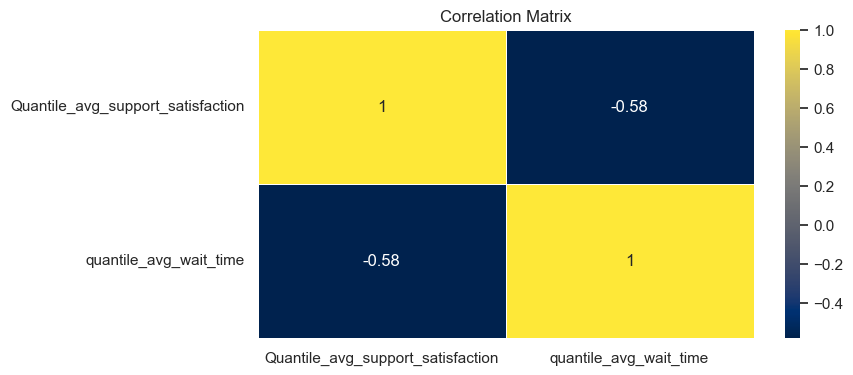

,Quantile_avg_support_satisfaction,quantile_avg_wait_time
Quantile_avg_support_satisfaction,1.000000,-0.575789
quantile_avg_wait_time,-0.575789,1.000000


In [411]:
corr = df2[['Quantile_avg_support_satisfaction', 'quantile_avg_wait_time']].corr()

plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, cmap='cividis', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
corr

There’s a  negative correlation between support satisfaction and wait time. As `avg_wait_time` increases, `avg_support_satisfaction` tends to decrease.

In [412]:
df2.sort_values('response_id_count')

,created_date,response_id_count,Quantile_avg_support_satisfaction,quantile_avg_wait_time
0,2021-10-17,5,-2.403297,-5.199338
70,2021-12-26,23,-1.938519,-0.106661
1134,2024-11-24,27,-2.087908,1.839077
148,2022-03-14,29,-0.068558,-0.479041
805,2023-12-31,31,1.080963,0.288921
...,...,...,...,...
1157,2024-12-17,255,-1.729552,2.329863
1123,2024-11-13,269,-1.260801,1.441512
1122,2024-11-12,276,-1.476122,1.667168
1150,2024-12-10,280,-1.408292,2.325630


In [415]:
# Compute rolling correlation
grouped_df['rolling_corr'] = df2['Quantile_avg_support_satisfaction'].rolling(window=7).corr(grouped_df['quantile_avg_wait_time'])

# Find the date with the strongest inverse correlation
strongest_inverse_date = grouped_df.loc[grouped_df['rolling_corr'].idxmin(), 'created_date']
print(f"Strongest inverse correlation observed on: {strongest_inverse_date}")
highlighted_point = grouped_df.loc[grouped_df['created_date'] == strongest_inverse_date]

Strongest inverse correlation observed on: 2024-11-06 00:00:00


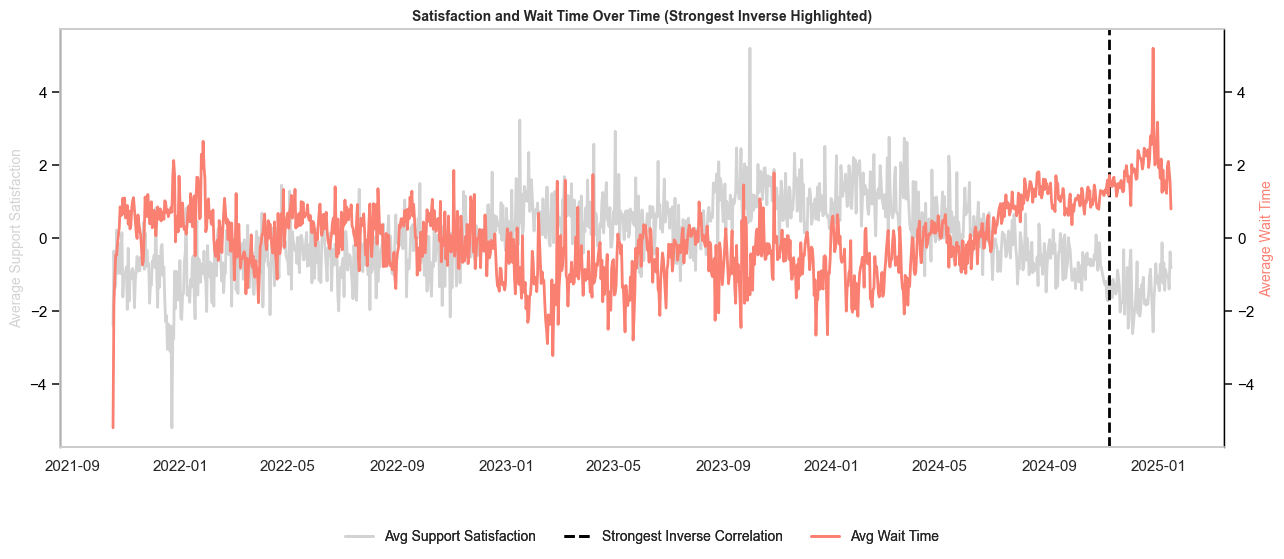

In [426]:
fig, ax1 = plt.subplots(figsize=(13, 5))

# Plot avg_support_satisfaction on the first y-axis

ax1.set_ylabel('Average Support Satisfaction', color='lightgrey', fontsize=10)
ax1.plot(grouped_df['created_date'], df2['Quantile_avg_support_satisfaction'], color='lightgrey', label='Avg Support Satisfaction', linewidth=2)
ax1.tick_params(axis='y', labelcolor='black')
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_linewidth(1)

ax2 = ax1.twinx()
ax2.set_ylabel('Average Wait Time', color='salmon', fontsize=10)
ax2.plot(grouped_df['created_date'], df2['quantile_avg_wait_time'], color='salmon', label='Avg Wait Time', linewidth=2)
ax2.tick_params(axis='y', labelcolor='black')
ax2.spines['right'].set_color('black')
ax2.spines['right'].set_linewidth(1)

ax1.axvline(x=strongest_inverse_date, color='black', linestyle='--', linewidth=2, label='Strongest Inverse Correlation')

ax1.grid(False)
ax2.grid(False)

plt.xticks(rotation=45)

fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=10, frameon=False)
plt.title('Satisfaction and Wait Time Over Time (Strongest Inverse Highlighted)', fontsize=10, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=10, frameon=False)
plt.show()


Intercept: 0.005865827538921153
Coefficients: [-0.57422249]
R^2: 0.3449743879257924


Text(0.5, 1.0, 'Linear Regression avg_support_satisfaction vs avg_wait_time')

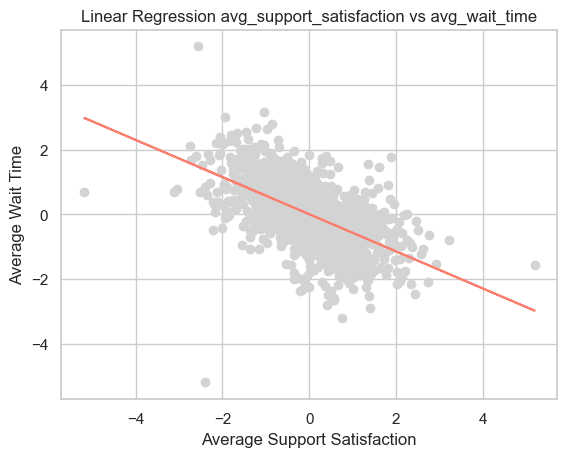

In [427]:
# Linerar Regression
X = df2[['Quantile_avg_support_satisfaction']]
y = df2['quantile_avg_wait_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

print('Intercept:', lr.intercept_)
print("Coefficients:", lr.coef_)
print("R^2:", lr.score(X_test, y_test))

# Plotting the regression line
plt.scatter(X, y, color='lightgrey', label='Data Points')
plt.plot(X, lr.predict(X), color='salmon', label='Regression Line')
plt.xlabel('Average Support Satisfaction')
plt.ylabel('Average Wait Time')
plt.title('Linear Regression avg_support_satisfaction vs avg_wait_time')


The model suggests an inverse relationship between satisfaction and wait time, but the low R² value indicates that the model doesn't explain a large proportion of the variance, meaning there may be other significant factors influencing the wait time that are not captured in this simple model.

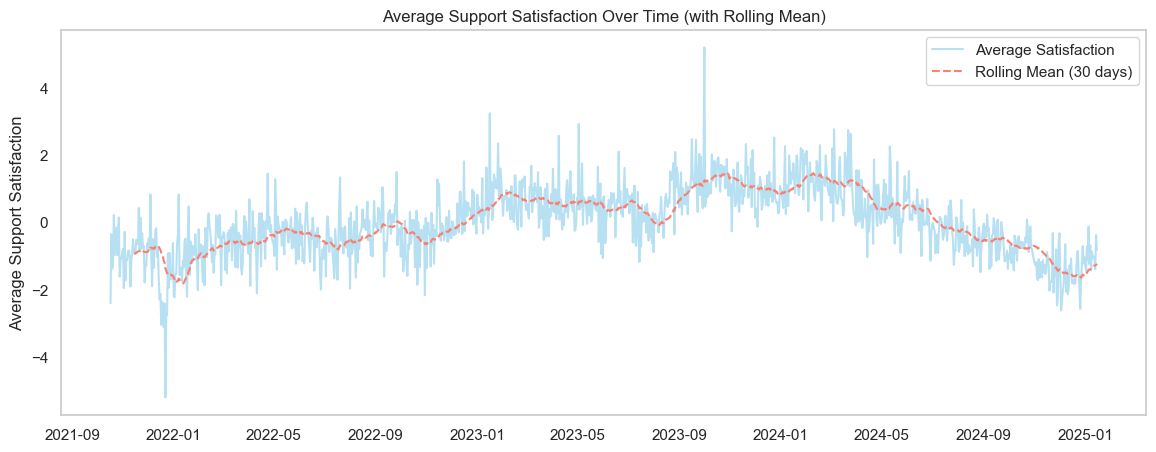

In [437]:
df3 = df2.groupby('created_date')['Quantile_avg_support_satisfaction'].mean()

# rolling mean (e.g., window of 30 days)
rolling_mean = df3.rolling(window=30).mean()

plt.figure(figsize=(14, 5))
plt.plot(df3, label='Average Satisfaction', color='skyblue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='salmon', linestyle='--')
plt.title('Average Support Satisfaction Over Time (with Rolling Mean)')
plt.ylabel('Average Support Satisfaction')
plt.legend()
plt.grid(False)

plt.show()

In [440]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(df2['Quantile_avg_support_satisfaction'], df2['quantile_avg_wait_time'])
print(f"Pearson Correlation: {corr}, P-value: {p_value}")

# If the p-value is <0.05, the correlation is statistically significant.

Pearson Correlation: -0.575788766545555, P-value: 9.20426690707245e-106


**Insights**
- Perason correlation Indicates a moderate negative linear relationship between the two variables.
- As one variable increases, the other tends to decrease.
- The negative correlation observed (-0.5758) is highly statistically significant.

In [442]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(grouped_df[['Quantile_avg_support_satisfaction', 'quantile_avg_wait_time']], maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=98.2647 , p=0.0000  , df_denom=1183, df_num=1
ssr based chi2 test:   chi2=98.5139 , p=0.0000  , df=1
likelihood ratio test: chi2=94.6357 , p=0.0000  , df=1
parameter F test:         F=98.2647 , p=0.0000  , df_denom=1183, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=29.0046 , p=0.0000  , df_denom=1180, df_num=2
ssr based chi2 test:   chi2=58.2550 , p=0.0000  , df=2
likelihood ratio test: chi2=56.8684 , p=0.0000  , df=2
parameter F test:         F=29.0046 , p=0.0000  , df_denom=1180, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.1966 , p=0.0000  , df_denom=1177, df_num=3
ssr based chi2 test:   chi2=39.8253 , p=0.0000  , df=3
likelihood ratio test: chi2=39.1702 , p=0.0000  , df=3
parameter F test:         F=13.1966 , p=0.0000  , df_denom=1177, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.4278  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(98.26469894329165),
    np.float64(2.634882995894217e-22),
    np.float64(1183.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(98.51389091018082),
    np.float64(3.2275271458503375e-23),
    np.int64(1)),
   'lrtest': (np.float64(94.6357447095711),
    np.float64(2.288483739595272e-22),
    np.int64(1)),
   'params_ftest': (np.float64(98.26469894329155),
    np.float64(2.634882995894423e-22),
    np.float64(1183.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(29.004621692616876),
    np.float64(5.049993443049194e-13),
    np.float64(1180.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(58.25504526398475),
    np.float64(2.2391214451166727e-13),
    np.int64(2)),
   'lrtest': (np.float64(56.8683895387976),
    np.float64(4.4790521013686017e-13),
    np.int64(2)),
   'params_ftest': (np.float64(29.004621692616826),
    np.float64(5.049993443049194e-13),
    np.float64(1180.0),
    2.0)},
   array([[0., 

**Summary:**
There is a short-term Granger causality (up to lag 6) between the variables, but no significant long-term causality (beyond lag 6).

The VAR (Vector Autoregression) order selection results indicate that the optimal lag order depends on the selection criterion:

In [443]:
from statsmodels.tsa.api import VAR
model = VAR(grouped_df[['Quantile_avg_support_satisfaction', 'quantile_avg_wait_time']])
selected_lags = model.select_order(maxlags=10)
print(selected_lags.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.3932     -0.3846      0.6749     -0.3899
1       -1.724      -1.698      0.1784      -1.714
2       -1.948      -1.905      0.1426      -1.931
3       -2.003      -1.942      0.1350      -1.980
4       -2.053      -1.976      0.1283      -2.024
5       -2.074      -1.980      0.1256      -2.039
6       -2.110     -1.998*      0.1212      -2.068
7       -2.124      -1.994      0.1196     -2.075*
8       -2.123      -1.976      0.1197      -2.068
9      -2.132*      -1.969     0.1186*      -2.071
10      -2.129      -1.948      0.1189      -2.061
--------------------------------------------------


`Given these results, we have a trade-off between model simplicity (lag 6) and predictive accuracy (lag 9). So we can say that the optimal lag order for this time series data is between 6 and 9 days.`


In [444]:
cd ~/Desktop/Folder
git pull origin main
git add CSAT_vs_time.ipynb
git commit -m "Add analysis notebook"
git push origin main

SyntaxError: invalid syntax (2847635373.py, line 1)